## Распознавание эмоций по тексту

In [184]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences

from wordcloud import WordCloud

import re
from pymystem3 import Mystem

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

import pickle

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

from IPython.utils import io

## Загрузка датасета

In [15]:
full_data_path = fr"C:\projects\Python\ML\DataBases\text_emotions\Text_Emotion.csv"

In [16]:
full_df = pd.read_csv(full_data_path)
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂
3,feel honored part group amazing talents,🙂
4,think helping also began feel pretty lonely lo...,☹️
...,...,...
282817,feel honored motivated share world life changi...,🙂
282818,feel like gloaty really delighted,🙂
282819,feel little energetic one day next several day...,🙂
282820,feel work experience fell although fantastic o...,🙂


In [17]:
full_df.emotion[full_df.emotion == '☹️'] = 0
full_df.emotion[full_df.emotion == '🙂'] = 1
full_df

,text,emotion
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1
2,not feeling super well turns cold knocked next...,1
3,feel honored part group amazing talents,1
4,think helping also began feel pretty lonely lo...,0
...,...,...
282817,feel honored motivated share world life changi...,1
282818,feel like gloaty really delighted,1
282819,feel little energetic one day next several day...,1
282820,feel work experience fell although fantastic o...,1


In [18]:
full_df.emotion = full_df.emotion.astype(int)

In [19]:
# примеры текста отрицательных эмоций
for true_value in full_df[full_df.emotion == 0]['text'].head(5):
    print(true_value)

carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations
think helping also began feel pretty lonely lot people used enjoy climbing moved really feel like anyone climb hard gym anymore
still feeling exhausted know strength gotten day
feeling extremely ugly right
waiting sun come back school called joey sore throat want summer make lunch love alllllllllllll


In [20]:
# примеры текста положительных эмоций
for true_value in full_df[full_df.emotion == 1]['text'].head(5):
    print(true_value)

cannot remember little mermaid feeling carefree beauty life gets lost somewhere massive piles homework budgeting finances eventually daunting choices life become adult
not feeling super well turns cold knocked next three weeks afterward hotter know head not
feel honored part group amazing talents
feel like pleasant nice around
cannot get feelings not trusting head


Предложения не похожи на написанные человеком. Они не являются полноценными. Слова идут обрывками и полный смысл предложения не понятен.

### Гипотеза: текст уже был предобработан

In [21]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

In [22]:
english_stop_words = stopwords.words('english')
snowball = SnowballStemmer(language='english')

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [23]:
for true_value in full_df[full_df.emotion == 1]['text'].head(10):
    print(len(true_value.split()), len(tokenize_sentence(true_value)))

22 21
15 13
6 6
5 5
6 4
5 4
5 5
10 9
5 5
19 18


до обработки

In [24]:
text_length = full_df.text.apply(len).to_list()  # длины строк с текстом
text_word_amout = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout += [len(i.split())]

обработка

In [25]:
english_stopwords = stopwords.words("english")

In [26]:
prep_texts = []
for t in tqdm(full_df.text):
    prep_texts.append(' '.join(tokenize_sentence(t)))

100%|██████████| 282822/282822 [00:28<00:00, 10100.06it/s]


после обработки

In [27]:
full_df['prep_text'] = prep_texts
full_df

,text,emotion,prep_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...
3,feel honored part group amazing talents,1,feel honor part group amaz talent
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...
...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...
282818,feel like gloaty really delighted,1,feel like gloati realli delight
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...


In [28]:
text_length2 = full_df.prep_text.apply(len).to_list()
text_word_amout2 = []  # количество слов в тексте (важно, тк при обработке происходит еще и стемминг)
for i in full_df.text:
    text_word_amout2 += [len(i.split())]

In [29]:
mean_len_diff = np.mean([abs(text_length2[i] - text_length[i]) for i in range(len(text_length))])
mean_amount_diff = np.mean([abs(text_word_amout2[i] - text_word_amout[i]) for i in range(len(text_word_amout))])

In [30]:
print(f'средняя разница длин строк до и после обработки: {mean_len_diff}')
print(f'средняя разница количества слов в строках до и после обработки: {mean_amount_diff}')

средняя разница длин строк до и после обработки: 8.757479969733613
средняя разница количества слов в строках до и после обработки: 0.0


Вывод: текст скорее всего уже был обработан по двум причинам: средняя разница количества слов в строках до и после обработки равна 0, предложения являются несвязными. Но обработка была другая, возмонжо, с использованием других библиотек. Обработка была неполной. К примеру, не был сделан стемминг и лемматизация

Основываясь на том, что гипотеза не была точно подтверждена или опровергнута, будут созданы несколько вариантов датасета: 
1) удаление специальных символов, чисел и пунктуации, стоп слов
2) удаление специальных символов, чисел и пунктуации, стоп слов + стемминг

## Создание датасета с различными степенями обработки данных

тк полностью обработанный датасет уже создан, просто переименовываем столбец с ним

In [34]:
# второй вариент датасета
full_df.columns = full_df.columns[:-1].to_list() + ['full_prep_text']

In [37]:
def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(sentence.lower())))]
    prep_text = ' '.join(prep_text)
    
    tokens = word_tokenize(prep_text, language = 'english')
    if remove_stop_words:
        tokens = [i for i in tokens if i not in english_stop_words]
    return tokens

In [40]:
prep_text = [' '.join(tokenize_sentence(text)) for text in full_df.text]

In [42]:
full_df['no_stem_text'] = prep_text

In [43]:
full_df

,text,emotion,full_prep_text,no_stem_text
0,carefully word blog posts amount criticism hea...,0,care word blog post amount critic hear place c...,carefully word blog posts amount criticism hea...
1,cannot remember little mermaid feeling carefre...,1,rememb littl mermaid feel carefre beauti life ...,remember little mermaid feeling carefree beaut...
2,not feeling super well turns cold knocked next...,1,feel super well turn cold knock next three wee...,feeling super well turns cold knocked next thr...
3,feel honored part group amazing talents,1,feel honor part group amaz talent,feel honored part group amazing talents
4,think helping also began feel pretty lonely lo...,0,think help also began feel pretti lone lot peo...,think helping also began feel pretty lonely lo...
...,...,...,...,...
282817,feel honored motivated share world life changi...,1,feel honor motiv share world life chang gift a...,feel honored motivated share world life changi...
282818,feel like gloaty really delighted,1,feel like gloati realli delight,feel like gloaty really delighted
282819,feel little energetic one day next several day...,1,feel littl energet one day next sever day hard...,feel little energetic one day next several day...
282820,feel work experience fell although fantastic o...,1,feel work experi fell although fantast opportu...,feel work experience fell although fantastic o...


In [51]:
full_df.dropna(inplace=True)

### Лемматизация 
В датасете не была проведена лемматизация, потому что это очень времязатратный процесс. Предположу, что отсутствие лемматизации не скажется на качестве модели и обучу сначала без нее.

In [44]:
'''mystem = Mystem()

lemm_texts = []
for text in tqdm(full_df.stem_text):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token not in (' ', '\n') and token not in english_stopwords]
        text = " ".join(tokens)
        lemm_texts.append(text)
    except Exception as e:
        print(e)'''

'mystem = Mystem()\n\nlemm_texts = []\nfor text in tqdm(full_df.stem_text):\n    try:\n        text_lem = mystem.lemmatize(text)\n        tokens = [token for token in text_lem if token not in (\' \', \'\n\') and token not in english_stopwords]\n        text = " ".join(tokens)\n        lemm_texts.append(text)\n    except Exception as e:\n        print(e)'

## Промежуточное сохранение
#### чтобы каждый раз не делать обработку, а просто загружать готовый датасет

In [52]:
full_df.to_csv('full_dataset_emotions_text.csv', index=False)

In [2]:
full_df = pd.read_csv('full_dataset_emotions_text.csv')

## Распределение длины текста

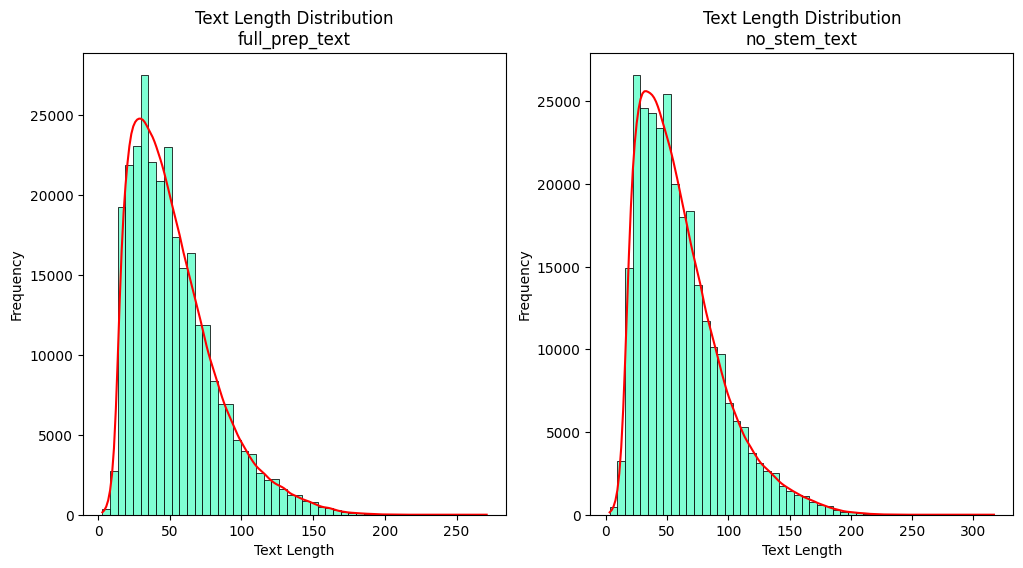

In [54]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    text_length = full_df[column].apply(len)
    sns.histplot(text_length, bins=50, color='red', kde=True, facecolor='aquamarine', ax=ax)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

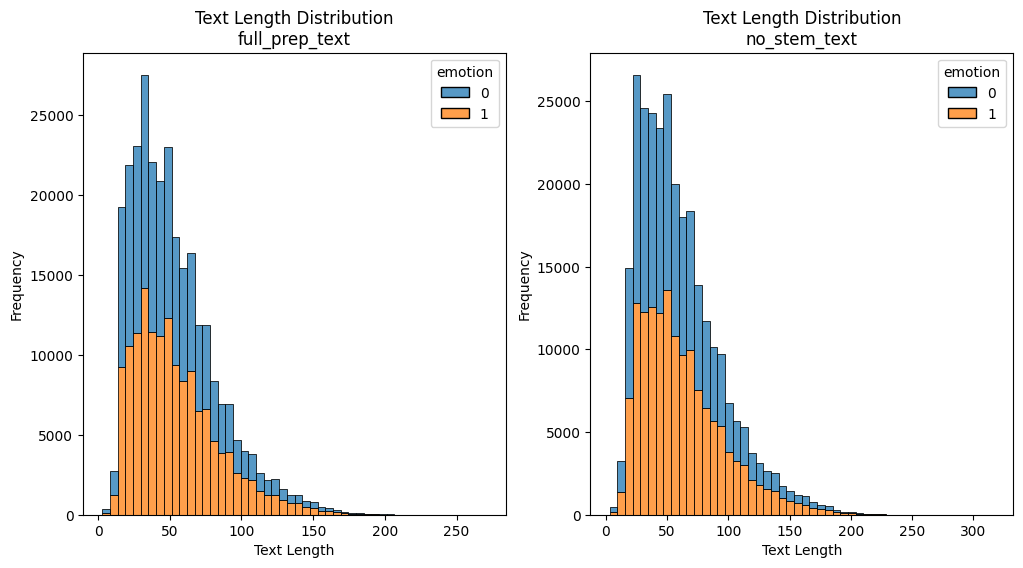

In [59]:
f, axes = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(12)

df = full_df.copy()

columns = full_df.columns.to_numpy()[2:]
for i, (column, ax) in enumerate(zip(columns, axes)):
    df['length'] = df[column].apply(len)
    sns.histplot(data=df, ax=ax, x='length', hue='emotion', multiple='stack', bins=50)
    ax.set_title(f'Text Length Distribution\n{column}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')

как показано на графике, распределение длины текста практически не отличается

## WordCloud

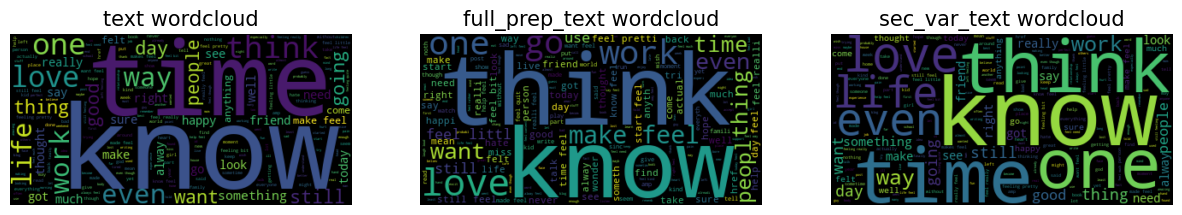

In [94]:
f, axes = plt.subplots(1, 3)
f.set_figheight(10)
f.set_figwidth(15)

columns = full_df.columns.to_numpy()[[0, 2, 3]]
for i, (column, ax) in enumerate(zip(columns, axes)):
    result = set(full_df[column])
    result_text = ' '.join(result)
    wordcloud = WordCloud().generate(result_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'{column} wordcloud', fontsize=15)

## Диаграмма распределения классов

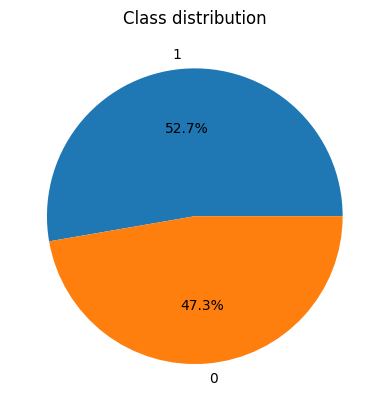

In [95]:
full_df.emotion.value_counts().plot(kind='pie', title='Class distribution', autopct='%1.1f%%')
plt.axis('off')
plt.show()

Распределение классов сбалансировано, следовательно, не нужно делать oversampling/undersampling

## Обучение всех доступных моделей sklearn 

In [87]:
import sys
sys.path.append('C:\projects\Python\ML_TOOLS')

In [88]:
from models_ml import Classifier

Кастомный класс предоставляет возможность обучить сразу все доступные внутри модели на тренировочных данных. Во время обучения выводятся процесс обучения и предупреждения по каждой модели

первый варинт обработки

In [84]:
x_train, x_test, y_train, y_test = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [85]:
x_train.shape, x_test.shape

((240397,), (42424,))

In [86]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)

In [87]:
x_test_features = vectorizer.transform(x_test)

In [9]:
with open('vectorizers/vect_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [11]:
with open('fitted_models/models_no_stem_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

второй вариант датасета

In [12]:
x_train, x_test, y_train, y_test = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [13]:
vectorizer = TfidfVectorizer()
x_train_features = vectorizer.fit_transform(x_train)
x_test_features = vectorizer.transform(x_test)

In [14]:
with open('vectorizers/vect_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
model = Classifier()
fitted_models = model.fit_all(x_train_features, y_train)

!Default models! 

===============BernoulliNB===============
WAS FITTED SUCCESSFULLY

===============CalibratedClassifierCV===============
WAS FITTED SUCCESSFULLY

===============CategoricalNB===============
FITTING FAILED: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

===============ClassifierChain===============
FITTING FAILED: ClassifierChain.__init__() missing 1 required positional argument: 'base_estimator'

===============ComplementNB===============
WAS FITTED SUCCESSFULLY

===============DecisionTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============DummyClassifier===============
WAS FITTED SUCCESSFULLY

===============ExtraTreeClassifier===============
WAS FITTED SUCCESSFULLY

===============FixedThresholdClassifier===============
FITTING FAILED: FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'

===============GaussianNB===============
FITTING FAILED: Sparse da

In [16]:
with open('fitted_models/models_full_prep_text.pickle', 'wb') as handle:
    pickle.dump(fitted_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Оценка обучения

загрузка данных по первому обучению

In [5]:
with open('fitted_models/models_no_stem_text.pickle', 'rb') as handle:
    fitted_models_no_stem = pickle.load(handle)

In [6]:
with open('vectorizers/vect_no_stem_text.pickle', 'rb') as handle:
    vectorizer_no_stem = pickle.load(handle)

In [7]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(full_df.no_stem_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [8]:
x_test_no_stem = vectorizer_no_stem.transform(x_test1)

загрузка данных по второму обучению

In [9]:
with open('fitted_models/models_full_prep_text.pickle', 'rb') as handle:
    fitted_models_full_prep = pickle.load(handle)

In [10]:
with open('vectorizers/vect_full_prep_text.pickle', 'rb') as handle:
    vectorizer_full_prep = pickle.load(handle)

In [11]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(full_df.full_prep_text, full_df.emotion, test_size=0.15, random_state=42, stratify=full_df.emotion)

In [12]:
x_test_full_prep = vectorizer_full_prep.transform(x_test2)

### Вывод метрик для каждой обученной модели

RadiusNeighborsClassifier выдает ошибку при попытке построения графика. Ошибка: No neighbors found for test samples array([   0,    2,    4, ..., 9991, 9994, 9996], dtype=int64), you can try using larger radius, giving a label for outliers, or considering removing them from your dataset

Сама ошибка возникает в результате неправильного подбора изначальных параметров. А тк модель была обучена на дефолтных (нельзя было изменить исходя из концепции метода fit_all), они не позволяют алгоритму работать корректно. Он просто не может найти соседей в заданном по дефолту радиусе 1. Поэтому данная модель будет просто исключена из тестов

In [14]:
del fitted_models_no_stem['RadiusNeighborsClassifier']
del fitted_models_full_prep['RadiusNeighborsClassifier']

In [193]:
def show_roc_auc(models, x_test, y_test):
    f, axes = plt.subplots(4, 4)
    f.set_figwidth(15)
    f.set_figheight(18)
    f.suptitle('Evaluation of models fitted on no_stem_text', fontsize=20)
    f.tight_layout()
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*4:], ax_row):
            score = model.predict(x_test)
            RocCurveDisplay.from_predictions(
            y_test,
            score,
            color="darkorange",
            plot_chance_level=True,
            ax=ax
            )
            ax.set_title(model_name)

In [194]:
def show_confusion_matrix(models, x_test, y_test):
    """не работает"""
    f, axes = plt.subplots(4, 4)
    f.set_figwidth(20)
    f.set_figheight(23)
    f.suptitle('Evaluation of models fitted on no_stem_text', fontsize=20)
    f.tight_layout()
    
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*4:], ax_row):
            model.confusion_matrix_display(x_test, y_test, ax=ax, colorbar=False)
            ax.set_title(model_name)

In [195]:
def show_confusion_matrix(models, x_test, y_test):
    f, axes = plt.subplots(4, 4)
    f.set_figwidth(20)
    f.set_figheight(23)
    f.suptitle('Evaluation of models fitted on no_stem_text', fontsize=20)
    f.tight_layout()
    
    for i, ax_row in enumerate(axes):
        for (model_name, model), ax in zip(list(models.items())[i*4:], ax_row):
            ax.set_title(model_name)
            ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, ax=ax, colorbar=False, cmap='cividis')

In [196]:
def show_report(models, x_test, y_test):
    df = pd.DataFrame()
    for model_name, model in models.items():
        with io.capture_output():  # нужно, чтобы метод report не выводил сообщения о том, какие метрики не удалось посчитать и причину
            pred = model.predict(x_test)
            df[model_name] = model.report(y_test, pred)
    return df

#### Для текста без стемминга

Построение roc_auc кривой

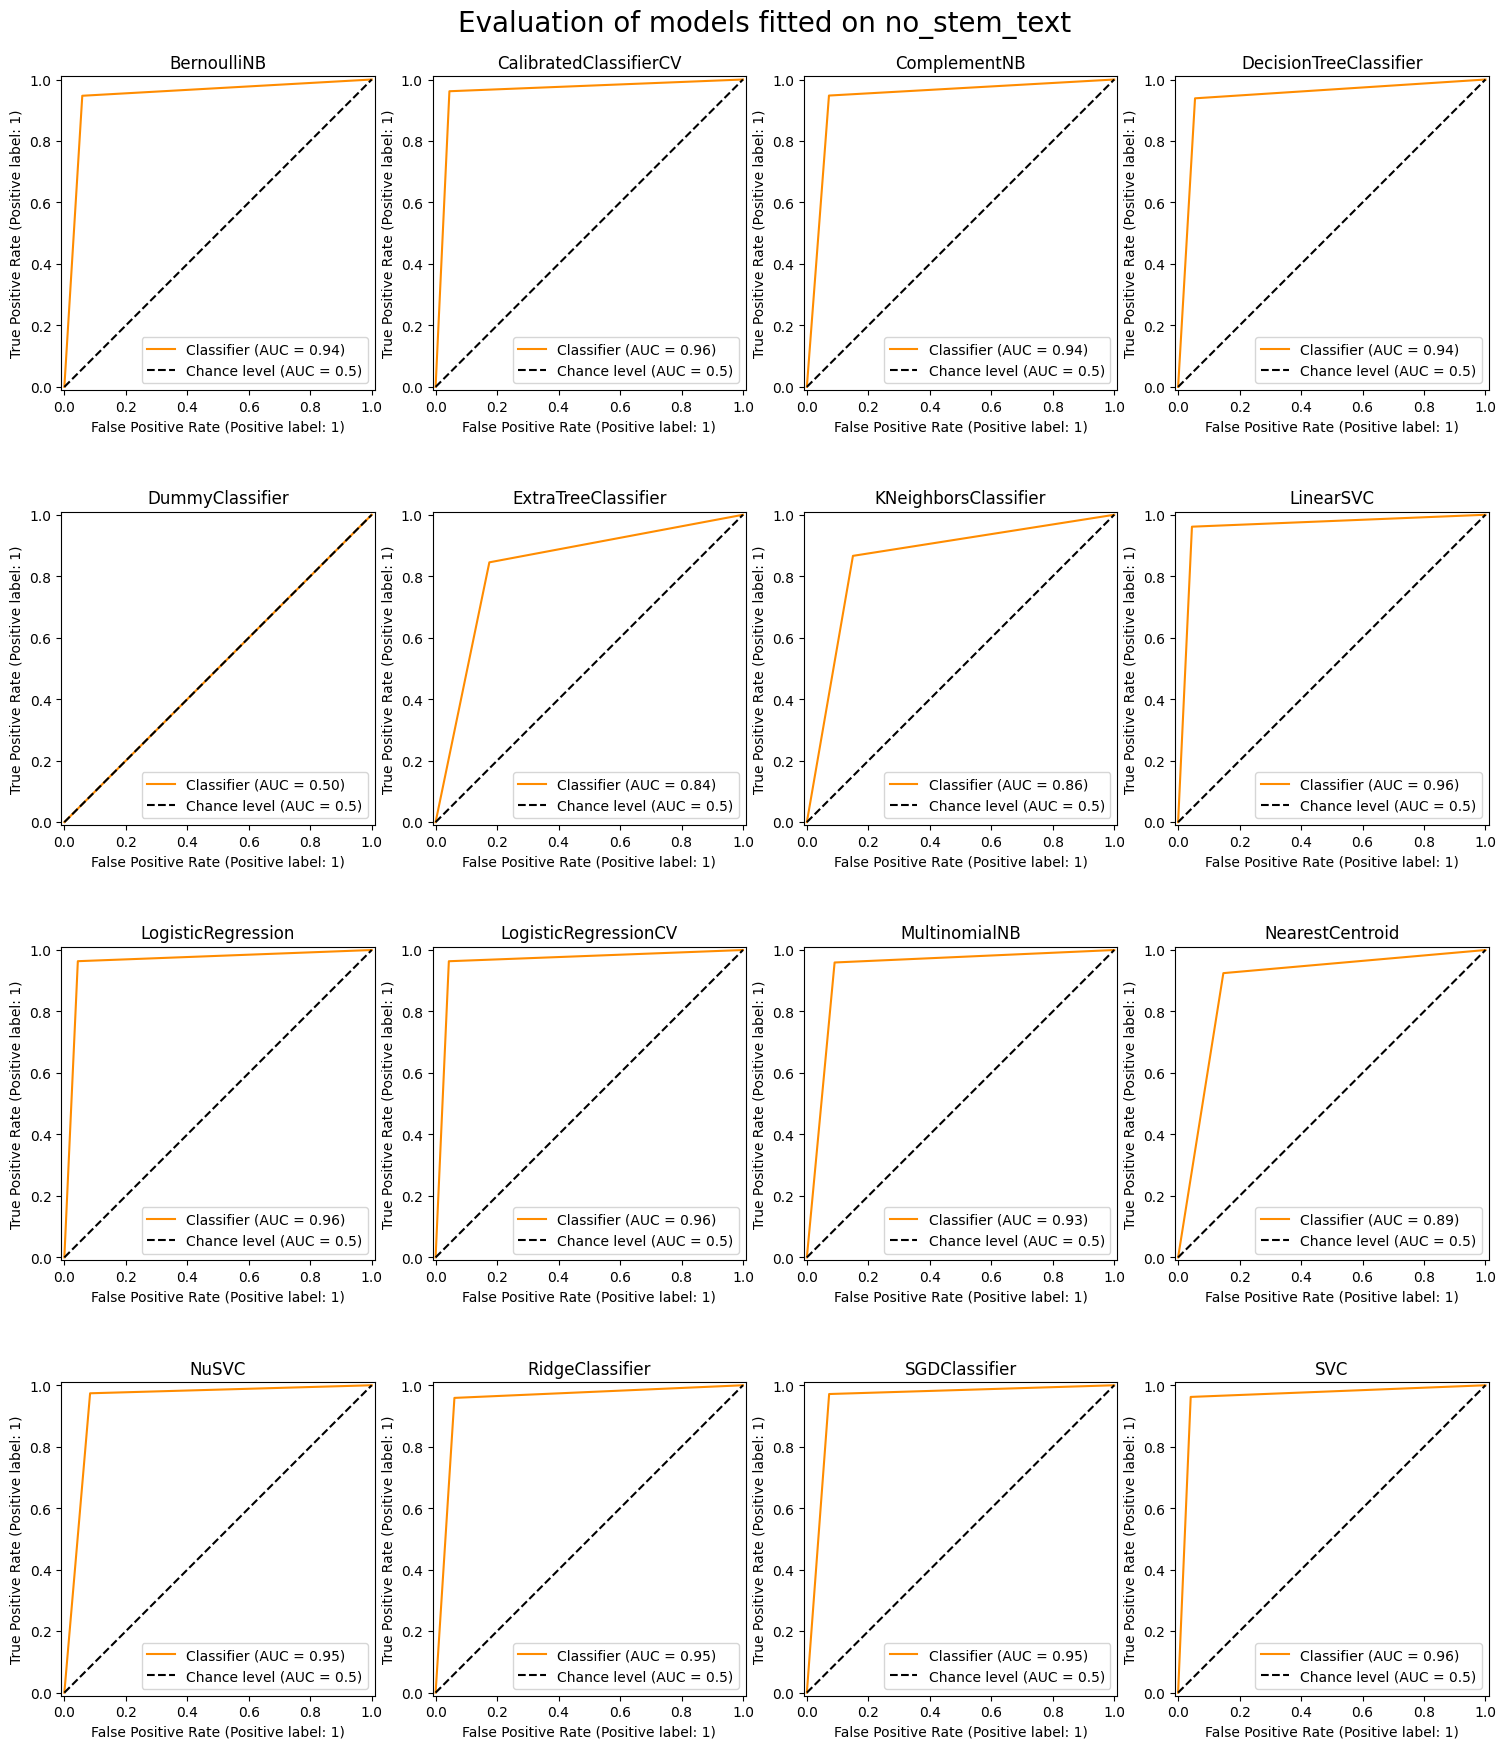

In [197]:
show_roc_auc(fitted_models_no_stem, x_test_no_stem, y_test1)

Вывод матрицы путаницы

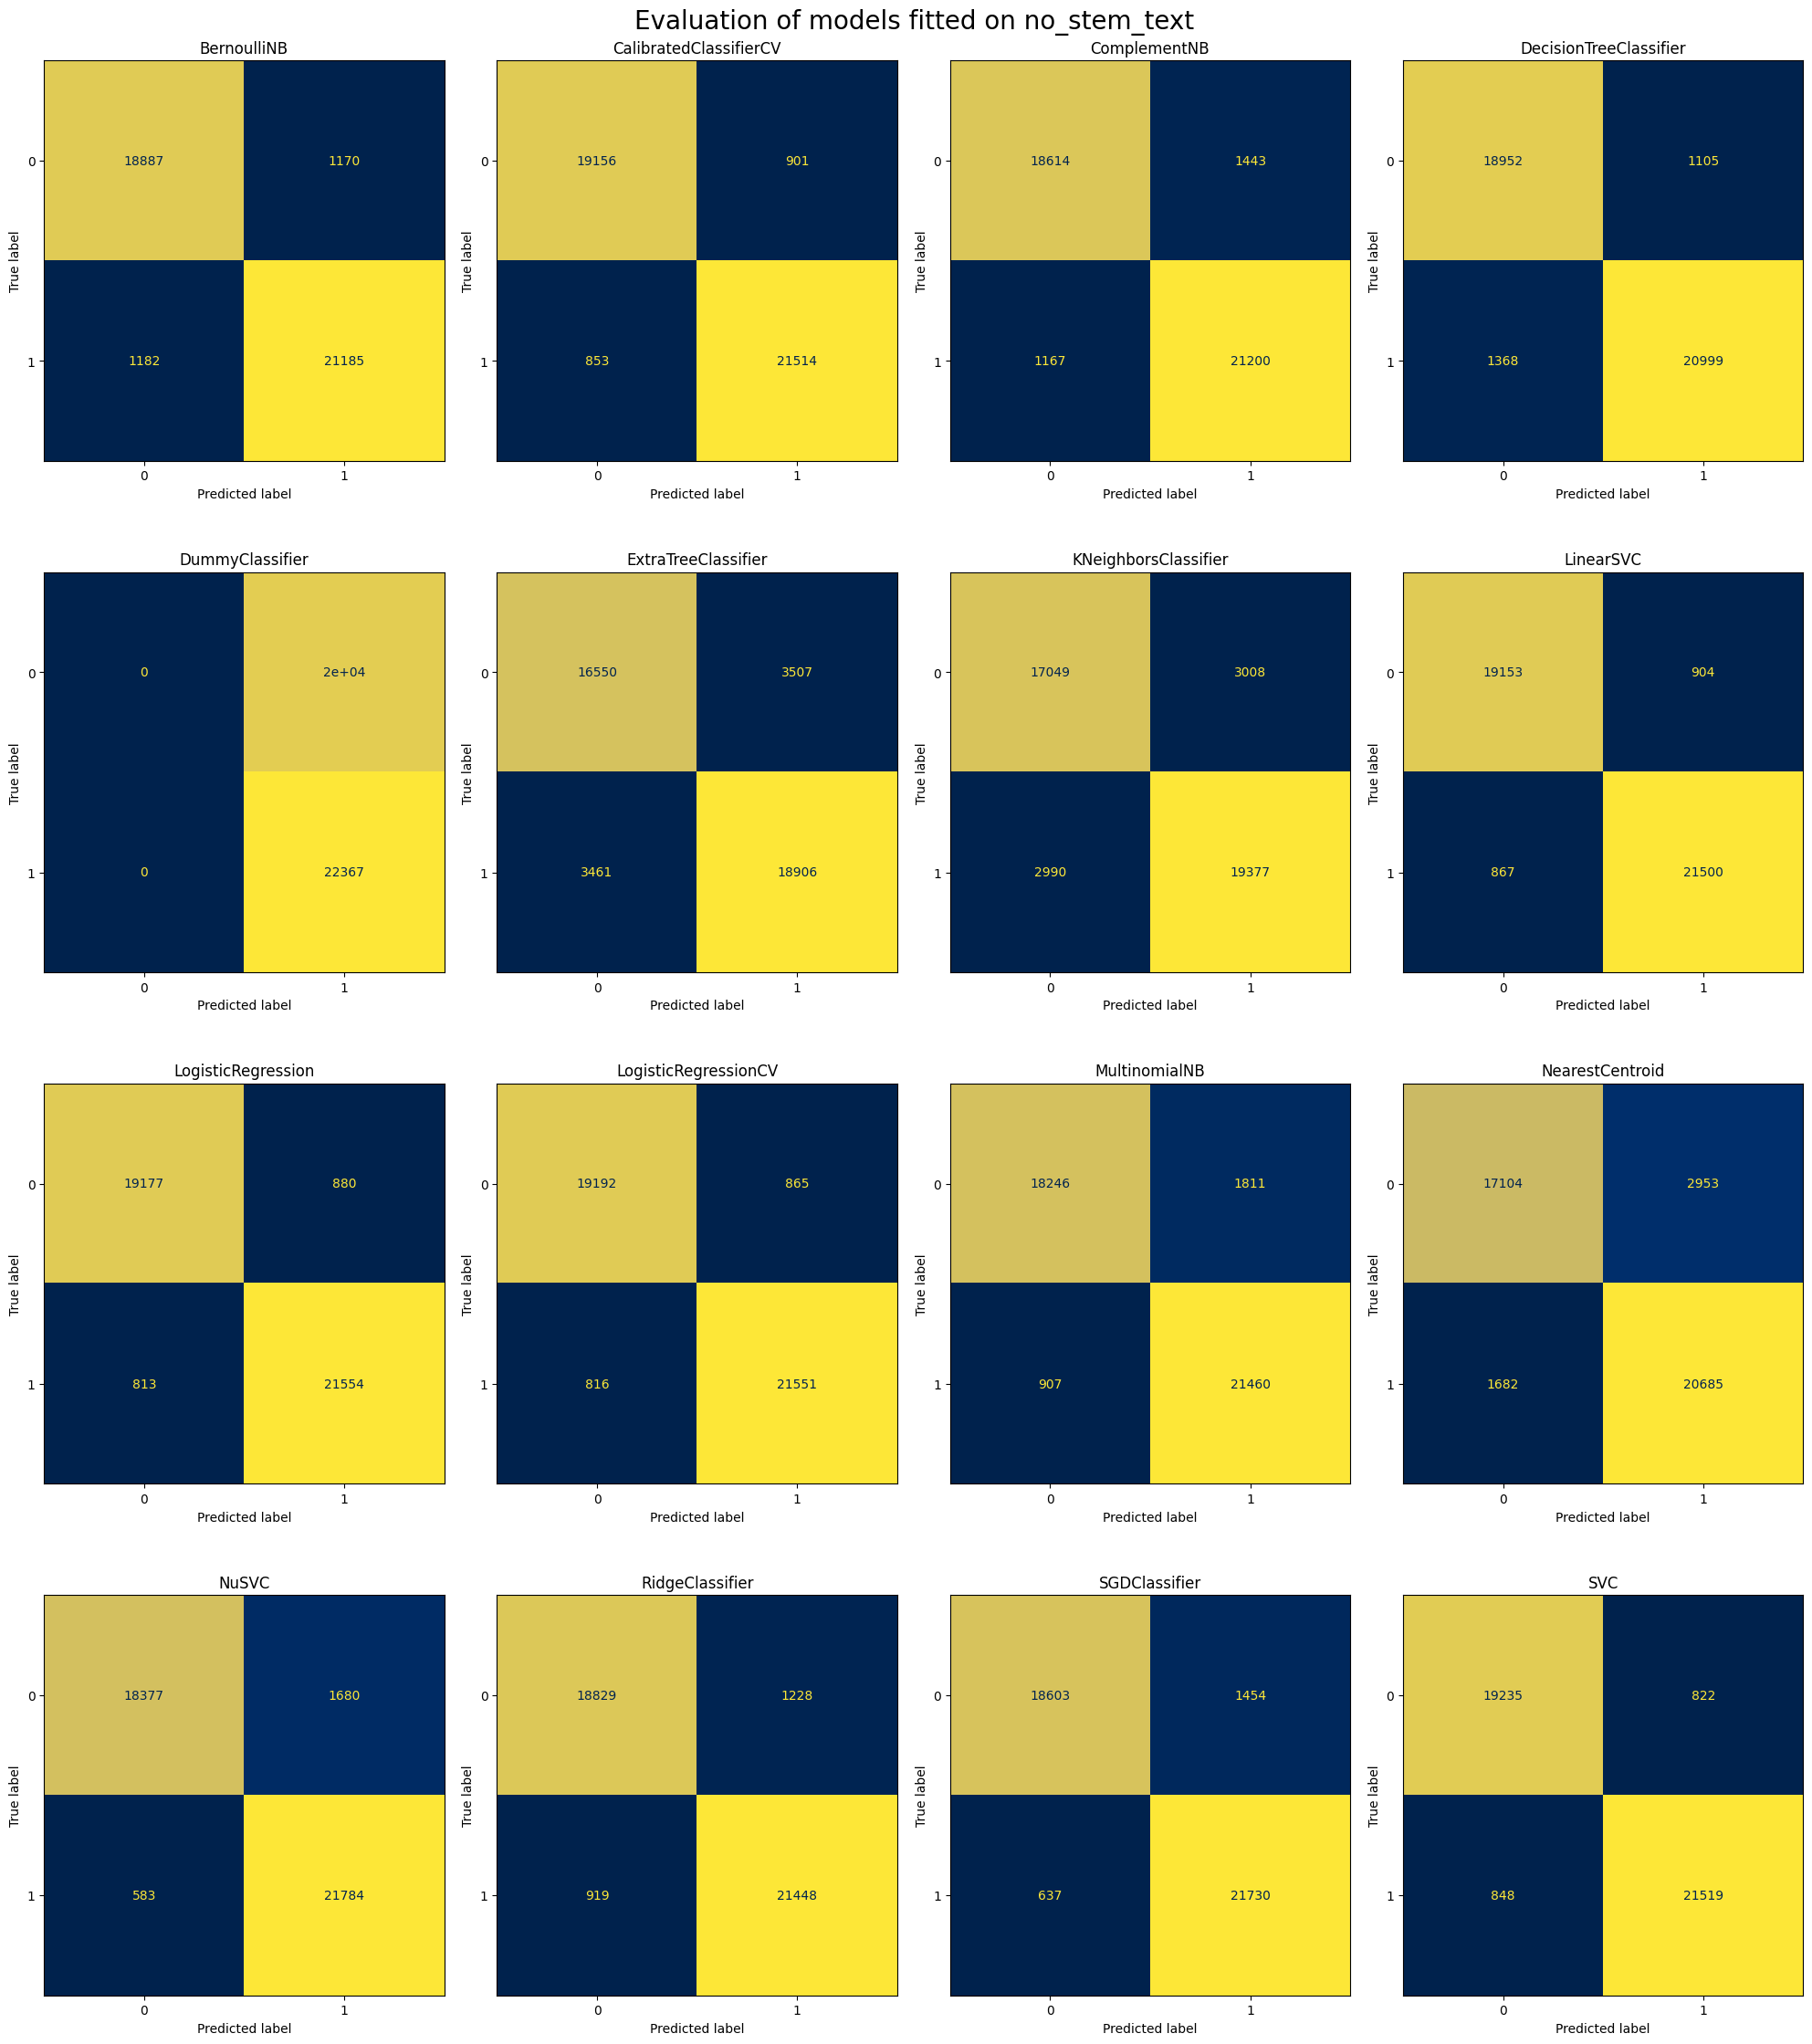

In [198]:
show_confusion_matrix(fitted_models_no_stem, x_test_no_stem, y_test1)

Вывод report

In [199]:
rep_no_stem = show_report(fitted_models_no_stem, x_test_no_stem, y_test1)

In [200]:
rep_no_stem

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,MultinomialNB,NearestCentroid,NuSVC,RidgeClassifier,SGDClassifier,SVC
accuracy_score,0.944560,0.958655,0.938478,0.941708,0.527225,0.835753,0.858618,0.958255,0.960093,0.960376,0.935932,0.890746,0.946658,0.949392,0.950712,0.960635
precision_score,0.947663,0.959804,0.936272,0.950009,0.527225,0.843528,0.865624,0.959650,0.960774,0.961411,0.922178,0.875074,0.928401,0.945846,0.937284,0.963207
recall_score,0.947154,0.961863,0.947825,0.938838,1.000000,0.845263,0.866321,0.961238,0.963652,0.963518,0.959449,0.924800,0.973935,0.958913,0.971521,0.962087
f1_score,0.947408,0.960832,0.942013,0.944391,0.690435,0.844395,0.865972,0.960443,0.962211,0.962463,0.940444,0.899250,0.950623,0.952334,0.954095,0.962647
d2_absolute_error_score,0.882734,0.912549,0.869871,0.876701,0.000000,0.652590,0.700952,0.911702,0.915591,0.916189,0.864486,0.768909,0.887172,0.892955,0.895747,0.916737
completeness_score,0.690382,0.751208,0.666664,0.679082,1.000000,0.354663,0.411246,0.749370,0.757821,0.759083,0.661813,0.507321,0.709419,0.711550,0.722464,0.760184
homogeneity_score,0.690413,0.751071,0.665898,0.679670,0.000000,0.354602,0.411218,0.749265,0.757627,0.758942,0.658718,0.503601,0.705149,0.710624,0.719492,0.760256
jaccard_score,0.900072,0.924618,0.890382,0.894640,0.527225,0.730695,0.763626,0.923897,0.927173,0.927643,0.887584,0.816943,0.905893,0.909006,0.912220,0.927983
brier_score_loss,0.055440,0.041345,0.061522,0.058292,0.472775,0.164247,0.141382,0.041745,0.039907,0.039624,0.064068,0.109254,0.053342,0.050608,0.049288,0.039365
d2_tweedie_score,0.777579,0.834130,0.753181,0.766137,-0.896723,0.341060,0.432789,0.832523,0.839899,0.841033,0.742968,0.561684,0.785996,0.796965,0.802261,0.842074


In [207]:
rep_no_stem.to_csv('reports/report_no_stem_text.csv')

#### Для обработанного текста

построение roc_auc кривой

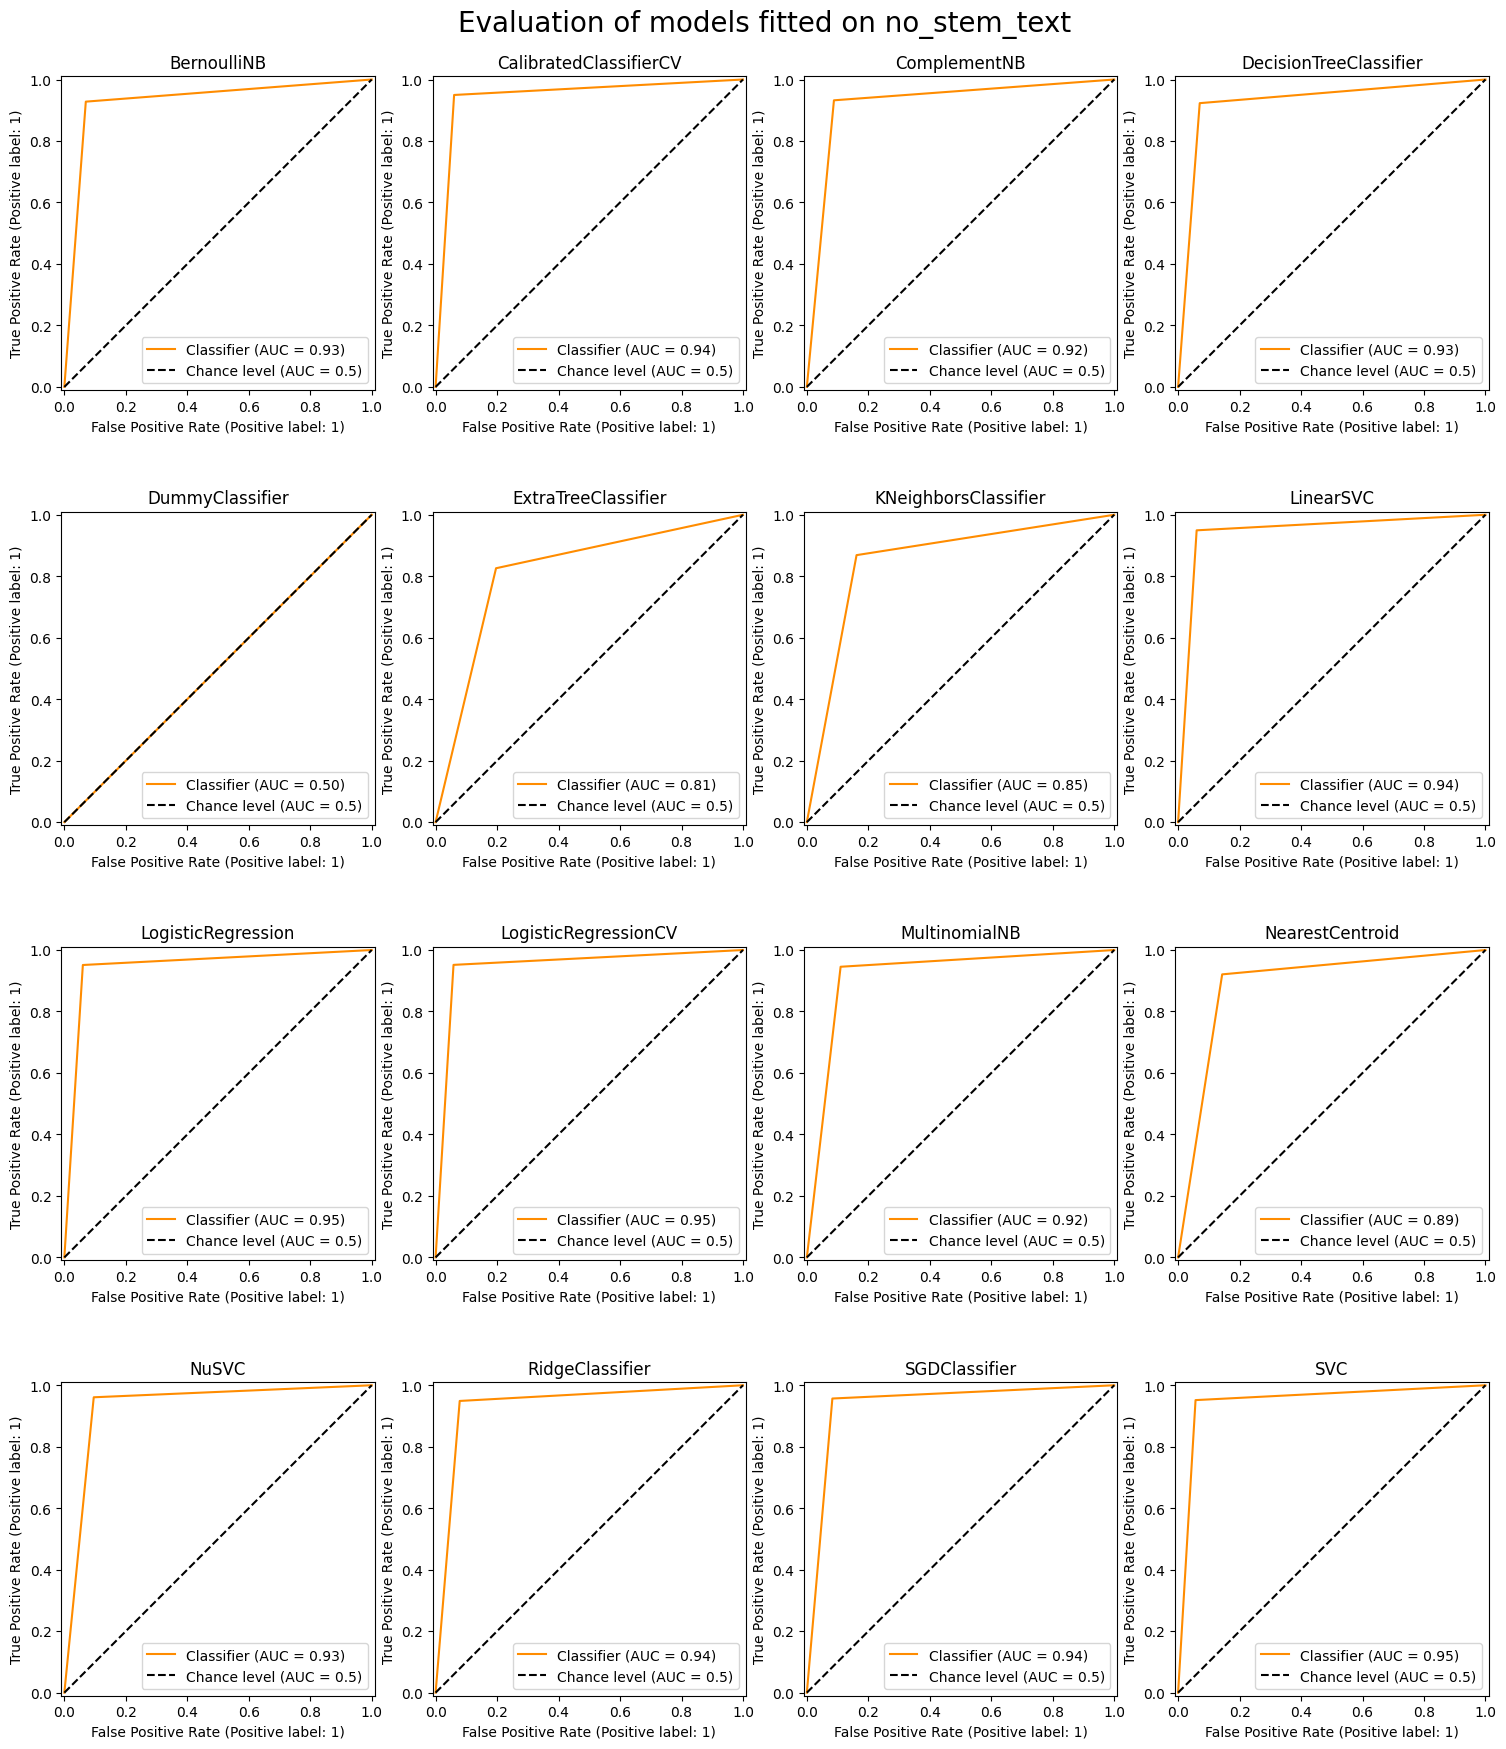

In [201]:
show_roc_auc(fitted_models_full_prep, x_test_full_prep, y_test2)

Вывод матрицы путаницы

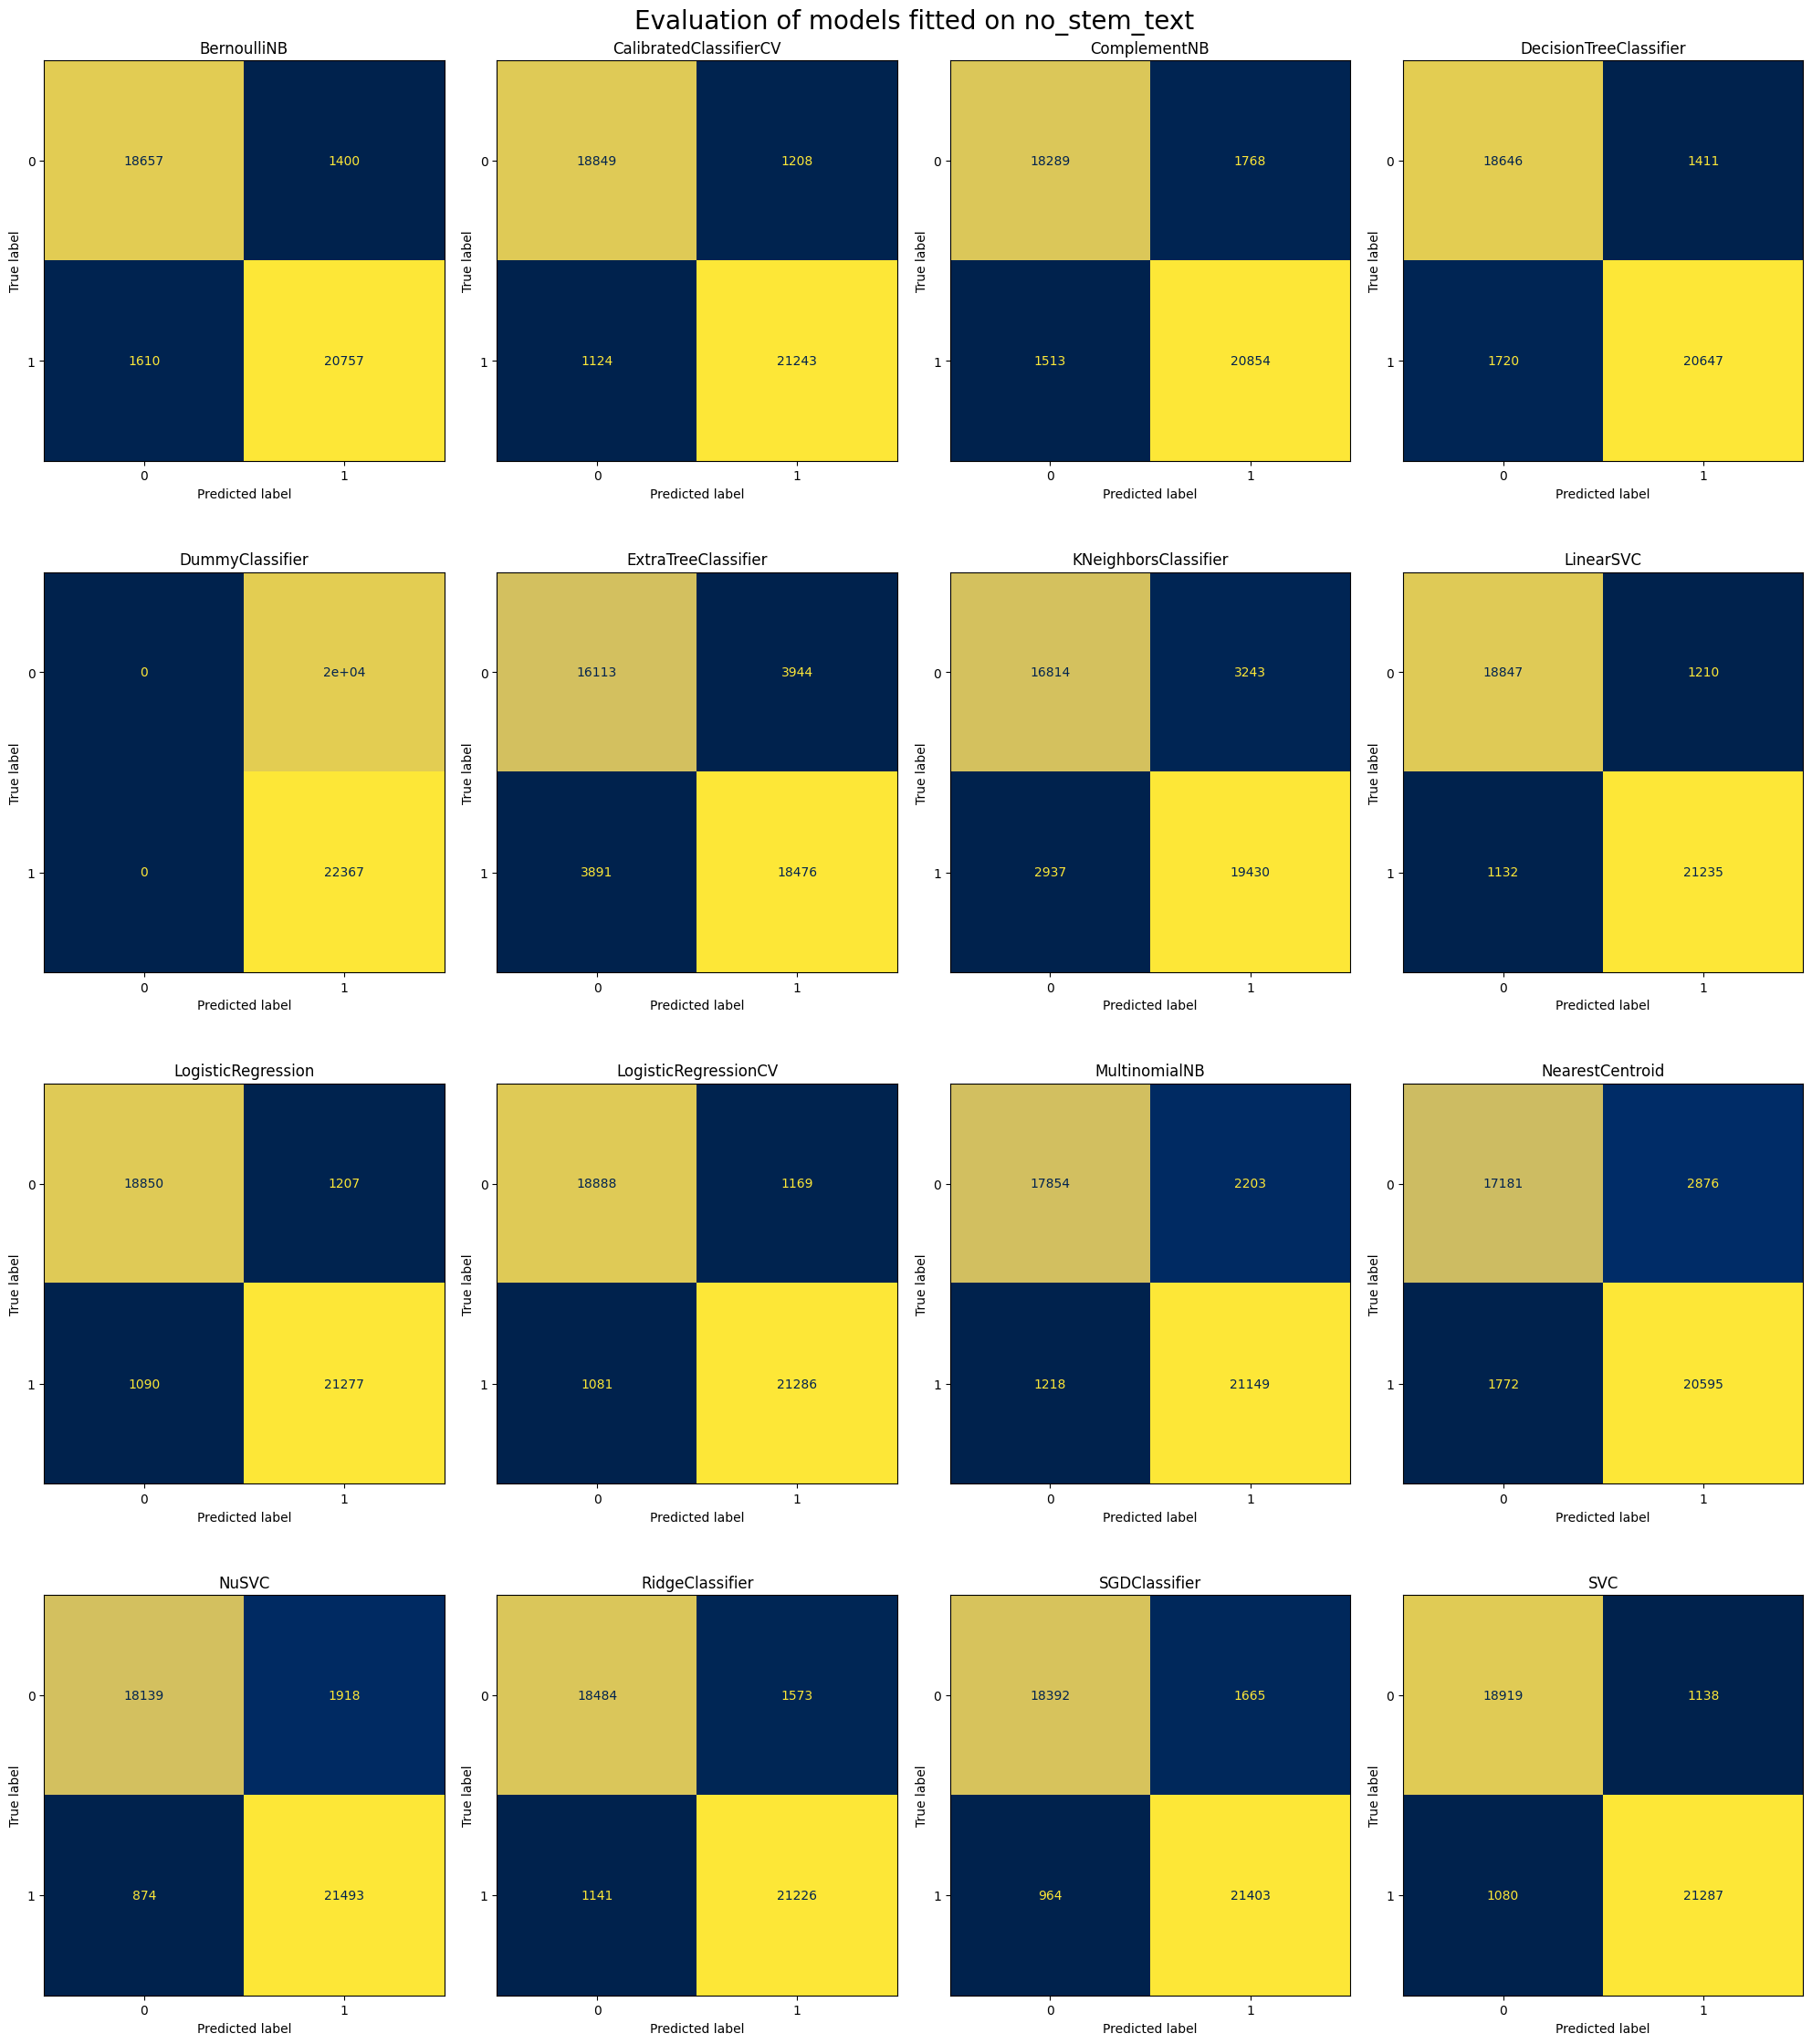

In [202]:
show_confusion_matrix(fitted_models_full_prep, x_test_full_prep, y_test1)

Вывод report

In [208]:
rep_full_prep = show_report(fitted_models_full_prep, x_test_full_prep, y_test2)

In [209]:
rep_full_prep

,BernoulliNB,CalibratedClassifierCV,ComplementNB,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,KNeighborsClassifier,LinearSVC,LogisticRegression,LogisticRegressionCV,MultinomialNB,NearestCentroid,NuSVC,RidgeClassifier,SGDClassifier,SVC
accuracy_score,0.929050,0.945031,0.922662,0.926197,0.527225,0.815317,0.854328,0.944795,0.945856,0.946964,0.919362,0.890439,0.934188,0.936027,0.938030,0.947718
precision_score,0.936815,0.946194,0.921846,0.936032,0.527225,0.824086,0.856966,0.946090,0.946317,0.947940,0.905661,0.877466,0.918073,0.931006,0.927822,0.949253
recall_score,0.928019,0.949747,0.932356,0.923101,1.000000,0.826038,0.868690,0.949390,0.951267,0.951670,0.945545,0.920776,0.960925,0.948987,0.956901,0.951715
f1_score,0.932396,0.947967,0.927071,0.929522,0.690435,0.825061,0.862789,0.947737,0.948786,0.949801,0.925173,0.898599,0.939010,0.939911,0.942137,0.950482
d2_absolute_error_score,0.849928,0.883731,0.836416,0.843895,0.000000,0.609363,0.691878,0.883233,0.885476,0.887820,0.829436,0.768260,0.860797,0.864686,0.868924,0.889415
completeness_score,0.630023,0.692446,0.607074,0.619720,1.000000,0.308780,0.400374,0.691465,0.695924,0.700455,0.600125,0.504968,0.656732,0.657854,0.667904,0.703548
homogeneity_score,0.630469,0.692222,0.606435,0.620336,0.000000,0.308718,0.399859,0.691258,0.695606,0.700218,0.596989,0.501903,0.653029,0.656601,0.665635,0.703392
jaccard_score,0.873354,0.901082,0.864056,0.868324,0.527225,0.702216,0.758688,0.900666,0.902562,0.904402,0.860765,0.815870,0.885032,0.886633,0.890604,0.905637
brier_score_loss,0.070950,0.054969,0.077338,0.073803,0.472775,0.184683,0.145672,0.055205,0.054144,0.053036,0.080638,0.109561,0.065812,0.063973,0.061970,0.052282
d2_tweedie_score,0.715354,0.779471,0.689727,0.703912,-0.896723,0.259070,0.415578,0.778525,0.782780,0.787225,0.676488,0.560454,0.735970,0.743346,0.751384,0.790251


In [210]:
rep_full_prep.to_csv('reports/report_full_prep_text.csv')

### обработка на русском

In [ ]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')

def tokenize_sentence2(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [ ]:
model_pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence2(x, remove_stop_words=True))),
    ('model', Classifier(LogisticRegression(random_state = 0)))
])

In [ ]:
model_pipeline2.fit(x_train, y_train.to_numpy())

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x000001FCB1BBB240>)),
                ('model', <models_ml.Classifier object at 0x000001FCA96EC350>)])

In [ ]:
y_pred2 = model_pipeline2.predict(x_test)

In [ ]:
model_pipeline2['model'].report(y_test, y_pred2)

Error calculating ndcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating dcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating fbeta_score: missing a required argument: 'beta'
Error calculating label_ranking_average_precision_score: binary format is not supported


c:\interpreter\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


{'accuracy_score': 0.9595156015203747,
 'precision_score': 0.9592994161801501,
 'recall_score': 0.9641240569991618,
 'f1_score': 0.961705685618729,
 'd2_absolute_error_score': 0.9143605086013463,
 'completeness_score': 0.7552978030890507,
 'homogeneity_score': 0.7549662132465396,
 'jaccard_score': 0.9262361088742148,
 'brier_score_loss': 0.04048439847962521,
 'd2_tweedie_score': 0.837579284795814,
 'cohen_kappa_score': 0.9187660749793872,
 'd2_pinball_score': 0.9143605086013463,
 'mutual_info_score': 0.5221793193060587,
 'adjusted_mutual_info_score': 0.7551163181980972,
 'average_precision_score': 0.9437999359971969,
 'balanced_accuracy_score': 0.9592497622318172,
 'top_k_accuracy_score': 1.0,
 'roc_auc_score': 0.9592497622318172,
 'gini': 0.9184995244636345}

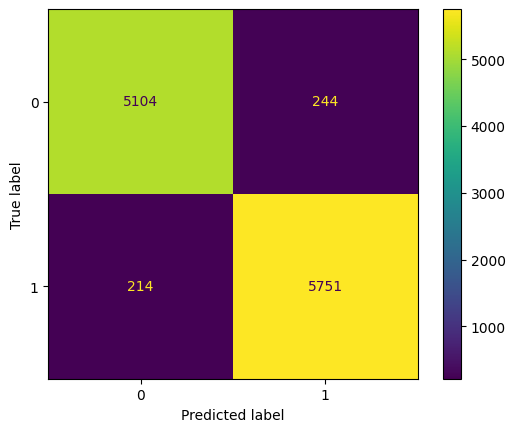

In [ ]:
model_pipeline2['model'].confusion_matrix_display(vectorizer.transform(x_test), y_test.to_numpy())

In [ ]:
probs = model_pipeline2.predict_proba(x_test)

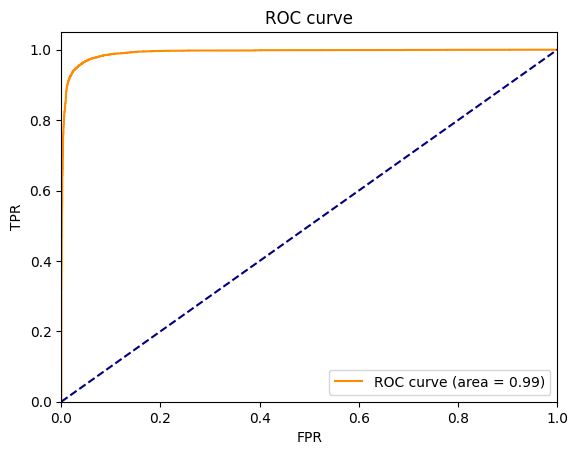

In [ ]:
model_pipeline2['model'].roc_auc_plot(y_test, probs[:, 1])

модель была незапланированно обучена на предобработке относительно русского языка, хотя датасет на английском. необходимо проверить, что будет, если обучить модель на английской предобработке

### обработка на английском

In [16]:
import sys

In [17]:
sys.path.append('C:\projects\Python\ML_TOOLS')

In [18]:
from models_ml import Classifier

In [316]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer = lambda x: tokenize_sentence(x))),
    ('model', Classifier(LogisticRegression(random_state = 0)))
])

In [317]:
model_pipeline.fit(x_train, y_train.to_numpy())

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000025D11BE5B20>)),
                ('model', <models_ml.Classifier object at 0x0000025D345E9DD0>)])

In [318]:
y_pred = model_pipeline.predict(x_test)

In [319]:
model_pipeline['model'].report(y_test, y_pred)

Error calculating ndcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating dcg_score: Only ('multilabel-indicator', 'continuous-multioutput', 'multiclass-multioutput') formats are supported. Got binary instead
Error calculating fbeta_score: missing a required argument: 'beta'
Error calculating label_ranking_average_precision_score: binary format is not supported


c:\interpreter\Lib\site-packages\sklearn\metrics\_ranking.py:2025: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(


{'accuracy_score': 0.6078847343763811,
 'precision_score': 0.6155008309412298,
 'recall_score': 0.6829840737636211,
 'f1_score': 0.647488874761602,
 'd2_absolute_error_score': 0.17053103964098726,
 'completeness_score': 0.032634474436507084,
 'homogeneity_score': 0.03201828476200669,
 'jaccard_score': 0.47873090481786135,
 'brier_score_loss': 0.39211526562361887,
 'd2_tweedie_score': -0.5731403769558276,
 'cohen_kappa_score': 0.2084234293249254,
 'd2_pinball_score': 0.17053103964098726,
 'mutual_info_score': 0.022145740894119192,
 'adjusted_mutual_info_score': 0.03226100680473503,
 'average_precision_score': 0.5875300979450897,
 'balanced_accuracy_score': 0.6035526202774725,
 'top_k_accuracy_score': 1.0,
 'roc_auc_score': 0.6035526202774726,
 'gini': 0.20710524055494517}

In [55]:
vectorizer = TfidfVectorizer(tokenizer = lambda x: tokenize_sentence2(x))
vectorizer.fit(x_train)

c:\interpreter\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function <lambda> at 0x000001FCAB6D5300>)

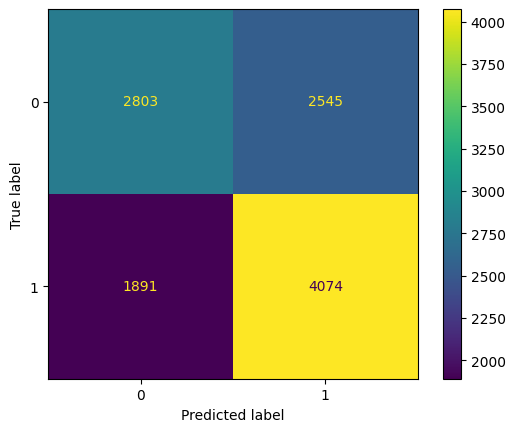

In [332]:
model_pipeline['model'].confusion_matrix_display(vectorizer.transform(x_test), y_test.to_numpy())

In [321]:
probs = model_pipeline.predict_proba(x_test)

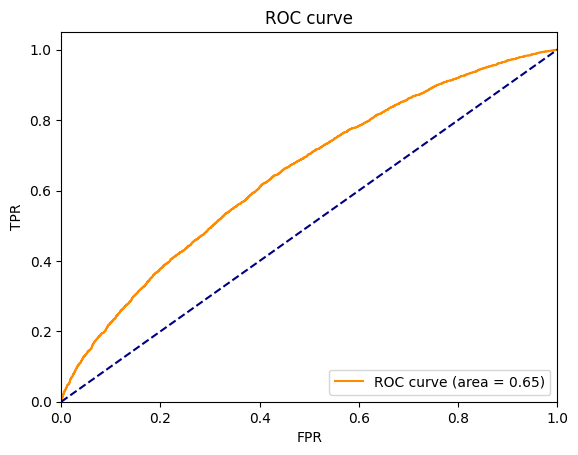

In [322]:
model_pipeline['model'].roc_auc_plot(y_test, probs[:, 1])

In [323]:
model_pipeline.predict(["here me out"])

array([0], dtype=int64)

модель, обученная на английской предобработке получила намного худшие метрики. следовательно, проверяем, что происходит при стемминге и удалении стоп слов относительно неверного языка

### проверка, что происходит во время обработки

#### на русском языке

In [42]:
russian_stop_words = stopwords.words('russian')
snowball = SnowballStemmer(language='russian')

def tokenize(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'russian')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [43]:
example = x_train.iloc[:10]
for ex in example:
    print(len(ex.split()), ex, '\n')

5 soooooooo damn hungry wat eat 

3 feeling appreciative blessings 

4 feel permanently damaged relationship 

8 feel happiness awe every time spot clever idea 

4 feel going popular used 

5 may feel little sliver hurt 

13 feeling quite energetic sleepiness moments thing recent past justin needed nap finished descent 

16 hear chorus grabs throat makes think dh immediately feel like kid reaching boom box blank tape 

9 observe thoughts feelings time learn nature mind free midst 

4 feel honoured remember words 



In [44]:
example = x_train.iloc[:10]
for ex in example:
    print(len(ex.split()), tokenize(ex), '\n')

5 ['soooooooo', 'damn', 'hungry', 'wat', 'eat'] 

3 ['feeling', 'appreciative', 'blessings'] 

4 ['feel', 'permanently', 'damaged', 'relationship'] 

8 ['feel', 'happiness', 'awe', 'every', 'time', 'spot', 'clever', 'idea'] 

4 ['feel', 'going', 'popular', 'used'] 

5 ['may', 'feel', 'little', 'sliver', 'hurt'] 

13 ['feeling', 'quite', 'energetic', 'sleepiness', 'moments', 'thing', 'recent', 'past', 'justin', 'needed', 'nap', 'finished', 'descent'] 

16 ['hear', 'chorus', 'grabs', 'throat', 'makes', 'think', 'dh', 'immediately', 'feel', 'like', 'kid', 'reaching', 'boom', 'box', 'blank', 'tape'] 

9 ['observe', 'thoughts', 'feelings', 'time', 'learn', 'nature', 'mind', 'free', 'midst'] 

4 ['feel', 'honoured', 'remember', 'words'] 



#### на английском языке

In [35]:
russian_stop_words = stopwords.words('english')
snowball = SnowballStemmer(language='english')

def tokenize(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language = 'english')
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [38]:
example = x_train.iloc[:10]
for ex in example:
    print(len(ex.split()), ex, '\n')

5 soooooooo damn hungry wat eat 

3 feeling appreciative blessings 

4 feel permanently damaged relationship 

8 feel happiness awe every time spot clever idea 

4 feel going popular used 

5 may feel little sliver hurt 

13 feeling quite energetic sleepiness moments thing recent past justin needed nap finished descent 

16 hear chorus grabs throat makes think dh immediately feel like kid reaching boom box blank tape 

9 observe thoughts feelings time learn nature mind free midst 

4 feel honoured remember words 



In [39]:
for ex in example:
    print(len(ex.split()), tokenize(ex), '\n')

5 ['soooooooo', 'damn', 'hungri', 'wat', 'eat'] 

3 ['feel', 'appreci', 'bless'] 

4 ['feel', 'perman', 'damag', 'relationship'] 

8 ['feel', 'happi', 'awe', 'everi', 'time', 'spot', 'clever', 'idea'] 

4 ['feel', 'go', 'popular', 'use'] 

5 ['may', 'feel', 'littl', 'sliver', 'hurt'] 

13 ['feel', 'quit', 'energet', 'sleepi', 'moment', 'thing', 'recent', 'past', 'justin', 'need', 'nap', 'finish', 'descent'] 

16 ['hear', 'chorus', 'grab', 'throat', 'make', 'think', 'dh', 'immedi', 'feel', 'like', 'kid', 'reach', 'boom', 'box', 'blank', 'tape'] 

9 ['observ', 'thought', 'feel', 'time', 'learn', 'natur', 'mind', 'free', 'midst'] 

4 ['feel', 'honour', 'rememb', 'word'] 



Вывод: данные действительно уже предобработаны, но не полностью. Были удалены только стоп слова. К примеру, не был сделан стемминг и лемматизация.
Причина: при обработке текста, используя 